# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [25]:
# Install requirements
!python -m pip install -r requirements.txt
!pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [30]:
!pip install ipywidgets 

Defaulting to user installation because normal site-packages is not writeable


## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307), (0.3081))])



train_data = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=transform)

train_len = int(len(train_data)*.8)
val_len = len(train_data) - train_len

train_subset, val_subset = torch.utils.data.random_split(train_data,[train_len, val_len])

train_load = DataLoader(train_subset, batch_size = 32, shuffle = True)
val_load = DataLoader(val_subset, batch_size = 32)
test_load = DataLoader(test_data, batch_size = 32)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

8


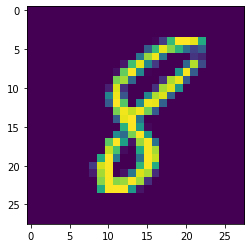

0


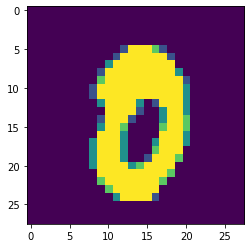

0


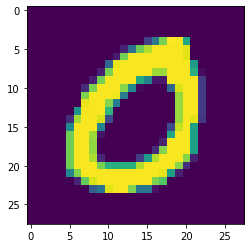

0


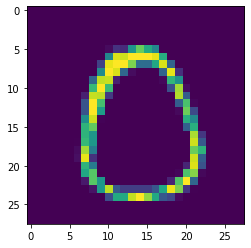

2


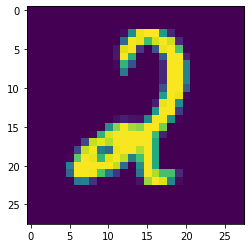

In [5]:
show5(train_load)
## YOUR CODE HERE ##

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [23]:
class MNIST_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.output = F.log_softmax
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.output(self.fc3(x), dim = 1)
        return x
    
mn = MNIST_net()
mn.to(device)

MNIST_net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

self.activationSpecify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [24]:
optimizer = optim.SGD(mn.parameters(), lr = .01) 
criterion = nn.NLLLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [25]:

epochs = 6
train_loss_hist = list()
test_loss_hist = list()
    
for epoch in range(epochs):
    mn.train()
    train_loss = 0
    train_correct  = 0
    for i, data in enumerate(train_load):
        inputs, label = data
        inputs, label = inputs.to(device), label.to(device)
            
            
        optimizer.zero_grad()
            
        outputs = mn(inputs)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == label).sum().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_load.dataset) * 100:.2f}% training loss: {train_loss/len(train_load.dataset):.5f}')
    train_loss_hist.append(train_loss/len(train_load))

        
        
    val_loss = 0
    val_correct = 0
    mn.eval()
        
    for inputs, label in val_load:
        inputs, label = inputs.to(device), label.to(device)
        outputs = mn(inputs)
        loss = criterion(outputs, label)
        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == label).sum().item()
        val_loss += loss.item()
            
    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(val_load.dataset)* 100:.2f}% validation loss: {val_loss/len(test_load.dataset):.5f}')
    test_loss_hist.append(val_loss/len(val_load))
        
        

      


Epoch 1 training accuracy: 82.50% training loss: 0.02033
Epoch 1 validation accuracy: 90.76% validation loss: 0.01210
Epoch 2 training accuracy: 92.11% training loss: 0.00850
Epoch 2 validation accuracy: 92.89% validation loss: 0.00929
Epoch 3 training accuracy: 93.84% training loss: 0.00661
Epoch 3 validation accuracy: 94.10% validation loss: 0.00769
Epoch 4 training accuracy: 95.04% training loss: 0.00535
Epoch 4 validation accuracy: 95.14% validation loss: 0.00641
Epoch 5 training accuracy: 95.89% training loss: 0.00450
Epoch 5 validation accuracy: 95.53% validation loss: 0.00571
Epoch 6 training accuracy: 96.47% training loss: 0.00386
Epoch 6 validation accuracy: 95.78% validation loss: 0.00518


# Plot the training loss (and validation loss/accuracy, if recorded).

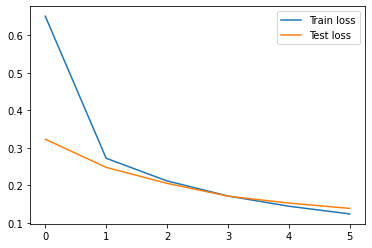

In [26]:
plt.plot(train_loss_hist, label = 'Train loss')
plt.plot(test_loss_hist, label = 'Test loss')
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [27]:
val_loss = 0
val_correct = 0
mn.eval()
        
for inputs, label in test_load:
    inputs, label = inputs.to(device), label.to(device)
    outputs = mn(inputs)
    loss = criterion(outputs, label)
    _, preds = torch.max(outputs.data, 1)
    val_correct += (preds == label).sum().item()
    val_loss += loss.item()
            
print(f'Epoch {epoch + 1} test accuracy: {val_correct/len(test_load.dataset)* 100:.2f}% test loss: {val_loss/len(test_load.dataset):.5f}')
test_loss_hist.append(val_loss/len(test_load))
        

Epoch 6 test accuracy: 96.25% test loss: 0.00386


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [4]:
transform_train = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307), (0.3081))])

transform_norm = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307), (0.3081))])



train_data = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=transform_train)
test_data = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=transform_norm)

train_len = int(len(train_data)*.8)
val_len = len(train_data) - train_len

train_subset, val_subset = torch.utils.data.random_split(train_data,[train_len, val_len])

train_load = DataLoader(train_subset, batch_size = 32, shuffle = True)
val_load = DataLoader(val_subset, batch_size = 32)
test_load = DataLoader(test_data, batch_size = 32)

In [16]:
class MNIST_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.output = F.log_softmax
        self.droput= nn.Dropout(.2)
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.droput(x)
        x = self.activation(self.fc2(x))
        x = self.output(self.fc3(x), dim = 1)
        return x
    
mn = MNIST_net()
mn.to(device)

MNIST_net(
  (droput): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [17]:
optimizer = optim.SGD(mn.parameters(), lr = .01) 
criterion = nn.NLLLoss()

In [18]:
epochs = 20
train_loss_hist = list()
test_loss_hist = list()
    
for epoch in range(epochs):
    mn.train()
    train_loss = 0
    train_correct  = 0
    for i, data in enumerate(train_load):
        inputs, label = data
        inputs, label = inputs.to(device), label.to(device)
            
            
        optimizer.zero_grad()
            
        outputs = mn(inputs)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == label).sum().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_load.dataset) * 100:.2f}% training loss: {train_loss/len(train_load.dataset):.5f}')
    train_loss_hist.append(train_loss/len(train_load))

        
        
    val_loss = 0
    val_correct = 0
    mn.eval()
        
    for inputs, label in val_load:
        inputs, label = inputs.to(device), label.to(device)
        outputs = mn(inputs)
        loss = criterion(outputs, label)
        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == label).sum().item()
        val_loss += loss.item()
            
    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(val_load.dataset)* 100:.2f}% validation loss: {val_loss/len(val_load.dataset):.5f}')
    test_loss_hist.append(val_loss/len(val_load))
        
        

Epoch 1 training accuracy: 80.81% training loss: 0.02171
Epoch 1 validation accuracy: 91.08% validation loss: 0.00983
Epoch 2 training accuracy: 90.95% training loss: 0.00951
Epoch 2 validation accuracy: 92.97% validation loss: 0.00761
Epoch 3 training accuracy: 93.01% training loss: 0.00745
Epoch 3 validation accuracy: 94.33% validation loss: 0.00603
Epoch 4 training accuracy: 94.30% training loss: 0.00599
Epoch 4 validation accuracy: 95.17% validation loss: 0.00512
Epoch 5 training accuracy: 95.15% training loss: 0.00520
Epoch 5 validation accuracy: 95.77% validation loss: 0.00444
Epoch 6 training accuracy: 95.72% training loss: 0.00457
Epoch 6 validation accuracy: 96.04% validation loss: 0.00406
Epoch 7 training accuracy: 96.21% training loss: 0.00405
Epoch 7 validation accuracy: 96.33% validation loss: 0.00369
Epoch 8 training accuracy: 96.52% training loss: 0.00367
Epoch 8 validation accuracy: 96.61% validation loss: 0.00348
Epoch 9 training accuracy: 96.78% training loss: 0.00336

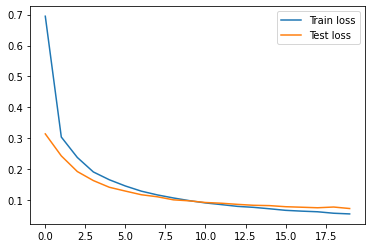

In [19]:
plt.plot(train_loss_hist, label = 'Train loss')
plt.plot(test_loss_hist, label = 'Test loss')
plt.legend()
plt.show()

In [20]:
val_loss = 0
val_correct = 0
mn.eval()
        
for inputs, label in test_load:
    inputs, label = inputs.to(device), label.to(device)
    outputs = mn(inputs)
    loss = criterion(outputs, label)
    _, preds = torch.max(outputs.data, 1)
    val_correct += (preds == label).sum().item()
    val_loss += loss.item()
            
print(f'Epoch {epoch + 1} test accuracy: {val_correct/len(test_load.dataset)* 100:.2f}% test loss: {val_loss/len(test_load.dataset):.5f}')
test_loss_hist.append(val_loss/len(test_load))
        

Epoch 20 validation accuracy: 97.75% validation loss: 0.00228


## Saving your model
Using `torch.save`, save your model for future loading.

In [21]:
torch.save(mn.state_dict(), 'model_mn')